# phylogeny of global M. bovis lineages

Make phylogeny from global and UK samples for strain naming

In [1]:
import sys,os,shutil,subprocess,time
import glob,random
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting, clustering
import toytree

In [9]:
#samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
#app.clean_bam_files(samples,'/storage/btbgenie/global_results/mapped/',True)

In [ ]:
reload(app)
reload(tools)
reload(aligners)
args = {'threads':12, 'outdir': '/storage/btbgenie/global_results', 'labelsep':'-',
        'input':['/storage/btbgenie/brites'],
         'species': 'Mbovis-AF212297', 'overwrite':False,
         'custom_filters': True,
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

In [ ]:
treefile1 = '/storage/btbgenie/global_results/tree.newick'
tre = toytree.tree(treefile1)
mystyle = { "layout": 'c','node_sizes':1,'tip_labels_align':True}
tre.draw(**mystyle,height=700);

## spoligotypes

In [ ]:
def get_spoligotypes(samples, spo=None):
    """Get spoligotypes for multiple M.bovis strains"""
    
    if spo is not None:
        done=list(spo['sample'])
    else:
        done=[]
    samples = samples.drop_duplicates('sample')
    res=[]
    for i,r in samples.iterrows():       
        f=r.filename1
        samp=r['sample']
        if samp in done:
            continue
        b = tools.get_spoligotype(f)
        sb = tools.get_sb_number(b)
        print (r['sample'], sb, b)
        res.append([r['sample'],sb,b])
    
    res = pd.DataFrame(res,columns=['sample','SB','code'])
    return res

spo = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
res = get_spoligotypes(samples,spo)

In [5]:
#res=pd.concat([spo,res])
#res.to_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')

## RD analysis

In [ ]:
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
from snipgenie import rdiff
reload(rdiff)
rdiff.create_rd_index()
res = rdiff.run_samples(samples,'/storage/btbgenie/global_results/rd_aligned',threads=10)
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
X.to_csv('/storage/btbgenie/global_results/rd.csv')

In [ ]:
reload(rdiff)
rdiff.show_rd_coverage(samples[:5], 'LT708304.1',4330000,4340000,app.mbovis_genome,margin=1300)

## merge to get metadata 

In [9]:
samples = pd.read_csv('/storage/btbgenie/global_results/samples.csv')
meta = pd.read_csv('brites_table1.csv')
x = samples.merge(meta,right_on='Accession_Number',left_on='sample',how='left')
spotypes = pd.read_csv('/storage/btbgenie/mbovis_ireland/spoligotypes.csv')
R = pd.read_csv('/storage/btbgenie/global_results/rd.csv',index_col=0)
meta = x.merge(spotypes,on='sample')
#rds=R[['RD1mic','RD149','RD3','RD5','RD5oryx*','RD122','RDAf2','RDWicklow']]
#meta = x.merge(rds,left_on='sample',right_index=True)
len(meta)

263

In [42]:
complexcolors = {'La2':'blue', 'La1.8.1':'pink', 'La1.3':'', 'La1.6':'', 'La1.7.1':'', 'La1.5':'', 'La3':'',
                'La1.8.2':'', 'La1.7-unk4':'', 'La1.2':'', 'La1.4':'', 'La1.7-unk5':'', 'La1.1':''}

array(['La2', 'La1.8.1', 'La1.3', 'La1.6', 'La1.7.1', 'La1.5', 'La3',
       'La1.8.2', 'La1.7-unk4', 'La1.2', 'La1.4', 'La1.7-unk5', 'La1.1'],
      dtype=object)

In [ ]:
R = pd.read_csv('/storage/btbgenie/global_results/rd.csv',index_col=0).iloc[:,:-1]
xcols = R.columns[(R.sum()<61) | (R.sum()>10)]
R[xcols]

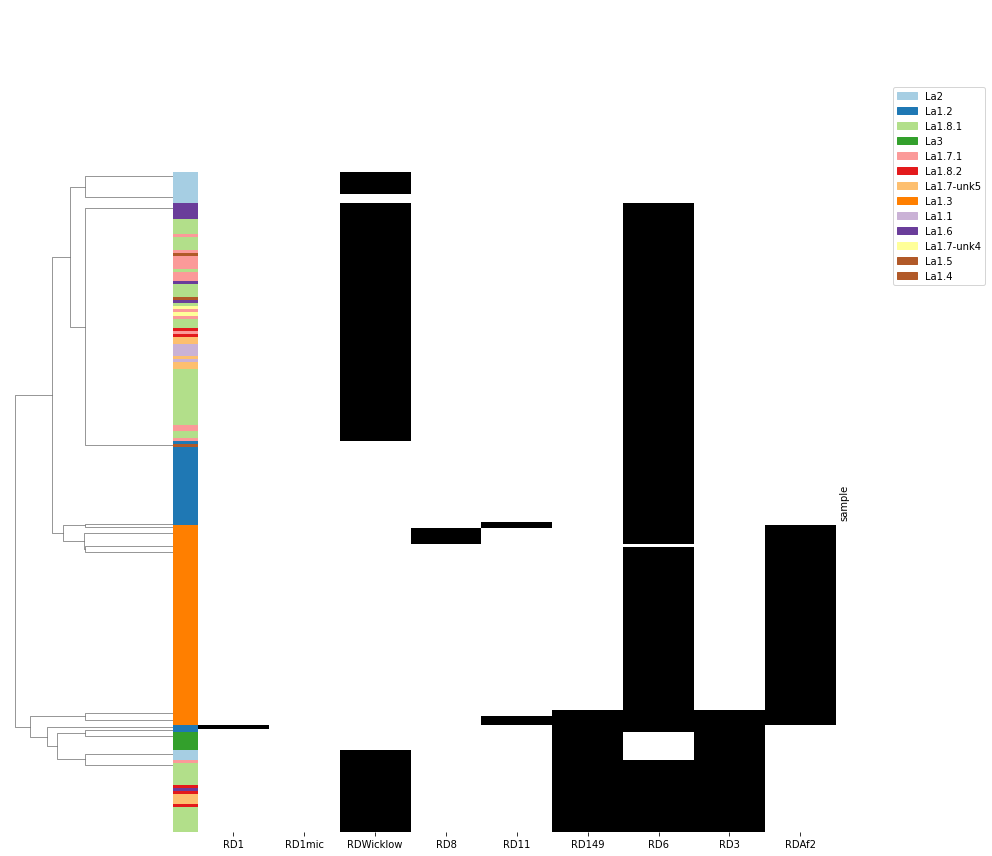

In [112]:
R = pd.read_csv('/storage/btbgenie/global_results/rd.csv',index_col=0)
#mapdict=dict(zip(meta['sample'],meta['SIB_Number']))
#X.index=X.index.map(mapdict)
scols=['sample','Clonal_Complex']
R=R.merge(meta[scols],left_index=True,right_on='sample',how='left').set_index('sample')

row_colors,colormap = get_color_mapping(R,'Clonal_Complex',cmap='Paired',seed=18)

cols = ['RD1','RD1mic','RDWicklow','RD8','RD11','RD149','RD6','RD3','RDAf2']


import matplotlib.patches as mpatches
g=sns.clustermap(R[cols],lw=0,cmap='gray_r',fmt='g',cbar_pos=None,col_cluster=False,
                 yticklabels=False,row_colors=row_colors,figsize=(12,12))
pts=[]
for c in colormap:
    pts.append(mpatches.Patch(color=colormap[c],label=c))
g.fig.legend(handles=pts,bbox_to_anchor=(1.15, .9))

In [ ]:
#treefile1 = '/storage/btbgenie/global_results/tree.newick'
#clusts = trees.get_clusters(treefile1)
#meta = meta.merge(clusts,left_on='sample',right_on='SequenceName')

In [10]:
meta.to_csv('/storage/btbgenie/global_results/metadata.csv',index=False)

## combine ireland + uk + global samples

add Ireland samples to global tree

In [6]:
outdir='/storage/btbgenie/combined_results'

folders = {'ireland':'/storage/btbgenie/all_ireland_results/',          
          'global':'/storage/btbgenie/global_results/'}

x=[]
for f in folders:
    print (f)
    file = os.path.join(folders[f],'samples.csv')
    df=pd.read_csv(file)
    
    x.append(df)
allsamples = pd.concat(x)
print (len(allsamples))
allsamples.to_csv(os.path.join(outdir,'samples.csv'),index=False)
app.write_samples(allsamples[['sample']], outdir)

ireland
global
1697


'/storage/btbgenie/combined_results/samples.txt'

## run variant calling on combined files

In [ ]:
reload(app)
bam_files = allsamples.bam_file
gff_file=os.path.join(outdir,'mbovis.gff')
tools.gff_bcftools_format(app.mbovis_gb, gff_file)
app.run_bamfiles(bam_files, app.mbovis_genome, outdir='/storage/btbgenie/combined_results', threads=12,
                 mask=app.mbovis_mask, gff_file=gff_file,
                 custom_filters=True, overwrite=False)

<div class="alert alert-block alert-info"><b>Start here for post analysis</b></div>

In [60]:
scols=['sample','SB','batch','county']
ireland = pd.read_csv('/storage/btbgenie/all_ireland_results/metadata.csv').iloc[:,:-7]
#ireland['Country']='Ireland'
print (len(ireland), len(meta))
master=pd.concat([ireland,meta])

1435 263


In [12]:
def get_common(x, common):
    if x in common:
        return x
    else:
        return 'Other'

In [61]:
common = master.Country.value_counts()[:9]
master['Country1'] = master.Country.apply(lambda x: get_common(x, common))
len(master)

1698

In [ ]:
#common = master.county.value_counts()[:4]
#master['county1'] = master.county.apply(lambda x: get_common(x, common))
#master['cc'] = master['Clonal_Complex'].fillna(master.Country)
#master['cc1'] = master['Clonal_Complex'].fillna(master.county1)

In [62]:
common = master.SB.value_counts()[:8]
master['SB1'] = master.SB.apply(lambda x: get_common(x, common))

[14, 4, 2, 1, 7, 8, 10, 3, 11, 9, 6, 13, 12]


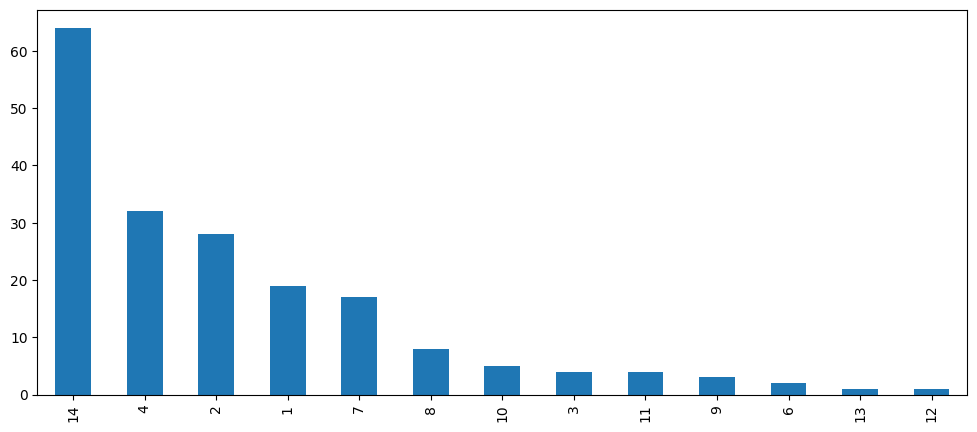

In [79]:
reload(clustering)
snpdist = pd.read_csv('/storage/btbgenie/combined_results/snpdist.csv',index_col=0)
clusts,members = clustering.get_cluster_levels(snpdist)
cc = clusts.snp500.value_counts()[1:20]
cc.plot(kind='bar',figsize=(12,5))
print (list(cc.index))
members.to_parquet("/storage/btbgenie/cluster_members.parquet")

In [80]:
st = clustering.generate_strain_names(clusts,snpdist)

In [83]:
final = master.merge(st,left_on='sample',right_index=True)

In [84]:
#combine rd data
rd1=pd.read_csv('/storage/btbgenie/global_results/rd.csv',index_col=0)
rd2=pd.read_csv('/storage/btbgenie/mbovis_ireland/rd.csv',index_col=0)
rd=pd.concat([rd1,rd2])
rvar = ['RD149','RD3','RD5','RD5oryx*','RDAf2','RDWicklow']
final = final.merge(rd[rvar],left_on='sample',right_index=True)

In [85]:
final.to_csv('/storage/btbgenie/combined_results/metadata.csv')

In [ ]:
cols=['sample','SB']
X=final.set_index(cols)[rvar].fillna(0)
#X = X.iloc[:,1:]
#print (X)
sns.clustermap(X,xticklabels=True,yticklabels=[],cmap='gray',figsize=(12,12))

In [93]:
meta.Clonal_Complex.value_counts()

La1.8.1       78
La1.3         64
La3           32
La1.2         26
La1.7.1       16
La2           13
La1.7-unk5     9
La1.6          8
La1.8.2        7
La1.1          5
La1.5          2
La1.7-unk4     2
La1.4          1
Name: Clonal_Complex, dtype: int64

## SNPs and indels clustering

In [ ]:
csq = app.read_csq_file('/storage/btbgenie/combined_results/csq.tsv')
snp_mat = app.get_aa_snp_matrix(csq)

In [ ]:
csqind = app.read_csq_file('/storage/btbgenie/combined_results/csq_indels.tsv')
#print (csqind)
#print (csqind.snp_type.value_counts())

ind_mat = app.get_aa_snp_matrix(csqind)
ind_mat.reset_index().snp_type.value_counts()
#ind_mat
#ind_mat[ind_mat.sum(1)>5]

In [ ]:
mat = snp_mat
#mat.index = mat.index.get_level_values(1)+'_'+mat.index.get_level_values(2)
stat = mat.sum(1).reset_index()
#stat.gene.value_counts()[:30]

In [ ]:
C=mat.T
C=C.merge(meta[cols],left_index=True,right_on='SRA ID').set_index(cols).T
C=C[C.sum(1)>3].T
C.iloc[:4,:2]

In [ ]:
countries = C.index.get_level_values(1)
sb = C.index.get_level_values(2)
clust = C.index.get_level_values(3)

In [ ]:
reload(trees)
colormap1 = dict(zip(sb.unique(), trees.qcolors))
colors1 = [colormap1[i] if i in colormap1 else 'Black' for i in sb]

colormap2 = dict(zip(clust.unique(), trees.qcolors))
colors2 = [colormap2[i] if i in colormap2 else 'Black' for i in clust]
#print (colors2)

g=sns.clustermap(C,xticklabels=False,yticklabels=True,figsize=(17,12),cmap='gray_r',cbar_pos=None,row_colors=colors2)
g.fig.savefig('/storage/btbgenie/global_results/indel_clusters.jpg')

## PCA snps

In [ ]:
import sklearn
from sklearn import decomposition
from sklearn import manifold

pca = decomposition.PCA(n_components=3)
mds = manifold.MDS(n_components=3)
pos = mds.fit(C).embedding_
X = pca.fit_transform(pos)
#X = pca.transform(C)

fig,ax = plt.subplots(figsize=(7, 7))
ax.scatter(X[:, 0], X[:, 1], c=colors2, s=100, alpha=.6)
